# Data Wrangling - 311 Data

### Data cleaning steps:
* Imported the City of Minneapolis's 311 data using an API (2017 and 2018 data), and by downloading a csv file (2016 data). (http://opendata.minneapolismn.gov/datasets?t=311)
* Formatted timestamps entries to be datetime values
* Created column called ‘days_open’, which calculates the difference between the opened_date and closed_date columns (in days).
* Set the index as the datetime each case was opened.
* Re-ordered the columns
* Merged the 2016 and 2017 data into one dataframe.
* Imported historical climate data by downloading a csv file from Minnesota's Department of Natural Resources. (https://www.dnr.state.mn.us/climate/historical/summary.html)
* Joined the climate data into the 311 dataframe, matching the date each case was opened.

### Missing values:
* Identified a large cluster of cases which had the same close date. It’s unclear if these close dates are accurate, or were filled in to avoid missing values. These cases will be explored further.
* The weather data contains mostly numerical data, with the exception of “T” entries. This stands for “trace amounts” of precipitation and snow fall. Considering changing “T” to a numeric value such as 0.05 or 0.01 (inches).

### Outliers:
* One case (a parking violation) lists the closed datetime as 3 seconds before it was opened. The ‘days_open’ value was updated to be zero. The case was opened 2017-10-30 08:40:03, id 101004098144.


In [1]:
import requests
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

## 311 Data - 2017

In [2]:
# Pull data from API - 311 2017
url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2017/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
r = requests.get(url)
api_json_data = r.json()
data_entries = api_json_data['features']

# Normalize the JSON data to populate tables from nested element
df17 = json_normalize(data_entries)


In [3]:
# Create new column names
new_col_names = ['case_id',
 'status', 'closed_date', 'enquiry_type_id', 'object_id', 'opened_date', 
 'reason', 'subject', 'title', 'type_name', 
 'x_coord', 'y_coord', 'x_geom', 'y_geom']

# Rename columns
df17.columns = new_col_names

# Sort by the unique identifier - opened_date
df17 = df17.sort_values(by = 'opened_date')


In [4]:
# Convert 'opened_date' values to datetime objects
df17['opened_date'] = df17['opened_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat())

# Convert 'closed_date' values to datetime objects, unless NaN
df17['closed_date'] = df17['closed_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat() 
                                               if pd.notnull(x) else x)

In [5]:
# Function to calculate the number of days between when each case was opened and closed.
def days_open(row):
    datetimeFormat = '%Y-%m-%dT%H:%M:%S'
    if pd.notnull(row['closed_date']):
        date_cl = row['closed_date']
        date_op = row['opened_date']
        diff = datetime.strptime(date_cl, datetimeFormat)\
            - datetime.strptime(date_op, datetimeFormat)
        return diff.days
    else:
        return np.nan

In [6]:
# Create new column that lists the number of days each case was open.
df17['days_open'] = df17.apply(lambda row: days_open(row), axis=1)


In [7]:
df17.head()

,case_id,status,closed_date,enquiry_type_id,object_id,opened_date,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
28842,101003980487,0,2017-01-01T07:01:08,101002281,28843,2016-12-31T19:22:11,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038507e+07,5.613839e+06,-93.290629,44.951182,0.0
28610,101003980490,0,2017-01-04T09:14:40,101000108,28611,2017-01-01T03:34:49,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.038661e+07,5.618705e+06,-93.304515,44.982106,3.0
28843,101003980492,0,2017-01-01T06:58:19,101002281,28844,2017-01-01T05:00:31,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038039e+07,5.620891e+06,-93.248613,44.995997,0.0
28844,101003980493,0,2017-01-01T06:23:32,101002281,28845,2017-01-01T05:26:03,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.037926e+07,5.618823e+06,-93.238468,44.982858,0.0
27143,101003980494,0,2017-01-04T12:39:50,101002221,27144,2017-01-01T06:38:05,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038154e+07,5.615371e+06,-93.258925,44.960918,3.0


In [8]:
# Convert dates to pandas datetime format.
df17['opened_date'] = pd.to_datetime(df17['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df17['closed_date'] = pd.to_datetime(df17['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Set the opened date as the index.
df17 = df17.set_index('opened_date')
df17.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2016-12-31 19:22:11,101003980487,0,2017-01-01 07:01:08,101002281,28843,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038507e+07,5.613839e+06,-93.290629,44.951182,0.0
2017-01-01 03:34:49,101003980490,0,2017-01-04 09:14:40,101000108,28611,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.038661e+07,5.618705e+06,-93.304515,44.982106,3.0
2017-01-01 05:00:31,101003980492,0,2017-01-01 06:58:19,101002281,28844,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038039e+07,5.620891e+06,-93.248613,44.995997,0.0
2017-01-01 05:26:03,101003980493,0,2017-01-01 06:23:32,101002281,28845,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.037926e+07,5.618823e+06,-93.238468,44.982858,0.0
2017-01-01 06:38:05,101003980494,0,2017-01-04 12:39:50,101002221,27144,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038154e+07,5.615371e+06,-93.258925,44.960918,3.0


## 311 Data - 2016

In [9]:
# Pull data from API - 311 2017
#url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2016/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
#r = requests.get(url)
#api_json_data = r.json()

#data_entries = api_json_data['features']
#df16 = json_normalize(data_entries)
#df16.info()

#api_json_data.keys()
#what_happened = api_json_data['exceededTransferLimit'] #true
#what_happened

The API for 2016 data returned only 1000 out of 51k rows. The 'exceededTransferLimit' line of the data was listed as "True". As an alternative, the data was downloaded as a CSV file.

In [10]:
df16 = pd.read_csv("311_Incidents_2016.csv")
df16.head()

,X,Y,CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,LastUpdateDate,OBJECTID
0,-93.235927,44.931412,101003863139,101000085,Streets,Street Maintenance,General Street Complaint,General Street Complaint,2016-03-18T08:54:34.000Z,0,2016-03-21T06:57:34.000Z,-1.037898e+07,5.610730e+06,2018-03-13T10:24:55.000Z,3001
1,-93.255669,44.988227,101003863146,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:02:08.000Z,0,2016-03-23T09:37:03.000Z,-1.038117e+07,5.619668e+06,2018-03-13T10:24:55.000Z,3002
2,-93.291268,44.950040,101003863162,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:32:10.000Z,0,2016-03-25T09:39:59.000Z,-1.038514e+07,5.613660e+06,2018-03-13T10:24:55.000Z,3003
3,-93.291268,44.950040,101003863163,101002181,Public Safety,Graffiti / Clean City,Graffiti - Open311,Graffiti - Open311,2016-03-18T09:32:10.000Z,0,2016-03-25T09:41:21.000Z,-1.038514e+07,5.613660e+06,2018-03-13T10:24:55.000Z,3004
4,0.000000,-0.000000,101003863180,101000172,Property,Private Property,Residential Conditions Complaint HOD Tenant,Residential Conditions Complaint HOD Tenant,2016-03-18T09:58:28.000Z,0,2016-03-22T19:36:03.000Z,0.000000e+00,0.000000e+00,2018-03-13T10:24:55.000Z,3005


In [11]:
# Standardize column names
new_col_names = [ 'x_geom', 'y_geom', 'case_id', 'enquiry_type_id',
                 'subject', 'reason', 'type_name', 'title',
                 'opened_date', 'status', 'closed_date', 
                 'x_coord', 'y_coord', 'last_update', 'object_id']

df16.columns = new_col_names
df16 = df16.sort_values(by = 'opened_date')


In [12]:
# The CSV file contains different date formatting than the API and JSON file.
# Thus, the days_open function was updated with new date formats.

def days_open_csv(row):
    datetimeFormat = '%Y-%m-%dT%H:%M:%S.%fZ'
    if pd.notnull(row['closed_date']):
        date_cl = row['closed_date']
        date_op = row['opened_date']
        diff = datetime.strptime(date_cl, datetimeFormat)\
            - datetime.strptime(date_op, datetimeFormat)
        return diff.days
    else:
        return np.nan

In [13]:
# Add column that lists the number of days until each case was closed.
df16['days_open'] = df16.apply(lambda row: days_open_csv(row), axis=1)


In [14]:
df16.head()


,x_geom,y_geom,case_id,enquiry_type_id,subject,reason,type_name,title,opened_date,status,closed_date,x_coord,y_coord,last_update,object_id,days_open
3195,-93.259481,44.950087,101003839191,101002221,Vehicles and Commuting,Traffic Control,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,2016-01-01T00:10:35.000Z,0,2016-01-02T12:03:41.000Z,-1.038160e+07,5.613667e+06,2018-03-13T10:24:54.000Z,2196,1
20549,-93.291802,44.965918,101003839192,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,2016-01-01T07:50:34.000Z,0,2016-01-02T09:08:54.000Z,-1.038520e+07,5.616158e+06,2018-03-13T10:24:54.000Z,29550,1
12632,-93.235196,45.024063,101003839193,101001081,Sidewalks,Snow & Ice,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,2016-01-01T08:46:35.000Z,0,2016-02-08T11:28:20.000Z,-1.037889e+07,5.625311e+06,2018-03-13T10:24:54.000Z,19633,38
12633,-93.290172,44.892400,101003839194,101000093,Vehicles and Commuting,Traffic Control,Parking Violation Complaint,Parking Violation Complaint,2016-01-01T09:35:17.000Z,0,2016-01-04T09:30:00.000Z,-1.038501e+07,5.604598e+06,2018-03-13T10:24:54.000Z,19634,2
3196,-93.276582,44.964583,101003839195,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,2016-01-01T10:00:34.000Z,0,2016-01-02T09:37:55.000Z,-1.038350e+07,5.615948e+06,2018-03-13T10:24:54.000Z,2197,0


In [15]:
# Convert dates to pandas datetime format.
df16['opened_date'] = pd.to_datetime(df16['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df16['closed_date'] = pd.to_datetime(df16['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Set the opened date as the index.
df16 = df16.set_index('opened_date')
df16.head()

,x_geom,y_geom,case_id,enquiry_type_id,subject,reason,type_name,title,status,closed_date,x_coord,y_coord,last_update,object_id,days_open
opened_date,,,,,,,,,,,,,,,
2016-01-01 00:10:35,-93.259481,44.950087,101003839191,101002221,Vehicles and Commuting,Traffic Control,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,0,2016-01-02 12:03:41,-1.038160e+07,5.613667e+06,2018-03-13T10:24:54.000Z,2196,1
2016-01-01 07:50:34,-93.291802,44.965918,101003839192,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,0,2016-01-02 09:08:54,-1.038520e+07,5.616158e+06,2018-03-13T10:24:54.000Z,29550,1
2016-01-01 08:46:35,-93.235196,45.024063,101003839193,101001081,Sidewalks,Snow & Ice,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,0,2016-02-08 11:28:20,-1.037889e+07,5.625311e+06,2018-03-13T10:24:54.000Z,19633,38
2016-01-01 09:35:17,-93.290172,44.892400,101003839194,101000093,Vehicles and Commuting,Traffic Control,Parking Violation Complaint,Parking Violation Complaint,0,2016-01-04 09:30:00,-1.038501e+07,5.604598e+06,2018-03-13T10:24:54.000Z,19634,2
2016-01-01 10:00:34,-93.276582,44.964583,101003839195,101002281,Vehicles and Commuting,Traffic Control,Parking Violation - Open311,Parking Violation - Open311,0,2016-01-02 09:37:55,-1.038350e+07,5.615948e+06,2018-03-13T10:24:54.000Z,2197,0


In [16]:
# Re-order the columns to align with the 2017 dataframe.
# The unnecessary "last_update" column is also removed.

df16 = df16[list(df17.columns)]
df16.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2016-01-01 00:10:35,101003839191,0,2016-01-02 12:03:41,101002221,2196,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038160e+07,5.613667e+06,-93.259481,44.950087,1
2016-01-01 07:50:34,101003839192,0,2016-01-02 09:08:54,101002281,29550,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038520e+07,5.616158e+06,-93.291802,44.965918,1
2016-01-01 08:46:35,101003839193,0,2016-02-08 11:28:20,101001081,19633,Snow & Ice,Sidewalks,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,-1.037889e+07,5.625311e+06,-93.235196,45.024063,38
2016-01-01 09:35:17,101003839194,0,2016-01-04 09:30:00,101000093,19634,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,Parking Violation Complaint,-1.038501e+07,5.604598e+06,-93.290172,44.892400,2
2016-01-01 10:00:34,101003839195,0,2016-01-02 09:37:55,101002281,2197,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038350e+07,5.615948e+06,-93.276582,44.964583,0


In [17]:
# Combine 2016 and 2017 call data
df1617 = df16.append(df17)

df1617.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106928 entries, 2016-01-01 00:10:35 to 2017-12-31 06:56:54
Data columns (total 14 columns):
case_id            106928 non-null int64
status             106928 non-null int64
closed_date        106325 non-null datetime64[ns]
enquiry_type_id    106928 non-null int64
object_id          106928 non-null int64
reason             106928 non-null object
subject            106928 non-null object
title              106928 non-null object
type_name          106928 non-null object
x_coord            106928 non-null float64
y_coord            106928 non-null float64
x_geom             106928 non-null float64
y_geom             106928 non-null float64
days_open          106325 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 12.2+ MB


## Search for Missing Values

In [18]:
df1617.closed_date.value_counts(dropna=False).head(20)

NaT                    603
2018-01-29 07:41:25    100
2018-01-29 07:39:05    100
2017-03-31 08:45:18     95
2018-01-29 07:36:39     95
2018-01-29 08:26:09     91
2017-03-31 13:45:55     91
2017-10-31 12:34:48     84
2017-03-31 13:47:49     68
2018-01-29 07:46:29     64
2018-01-29 08:27:21     63
2017-10-31 12:34:49     60
2017-10-31 12:34:47     55
2018-01-29 08:55:44     55
2018-01-29 08:53:38     29
2017-10-31 17:34:48     23
2017-10-31 17:34:47     18
2017-10-31 17:34:49     17
2017-06-12 03:03:54     10
2017-06-12 02:54:32      9
Name: closed_date, dtype: int64

1. The 603 missing values are cases that are still open. No close date is expected.
2. Why were so many cases closed on 2018-01-29 and 2017-03-31? Are they a group of cases?

## Search for Outliers

In [19]:
df1617.describe()

,case_id,status,enquiry_type_id,object_id,x_coord,y_coord,x_geom,y_geom,days_open
count,1.069280e+05,106928.000000,1.069280e+05,106928.000000,1.069280e+05,1.069280e+05,1.069280e+05,1.069280e+05,106325.000000
mean,1.010040e+11,0.005639,1.010008e+08,26759.527533,-9.607225e+06,5.196746e+06,-8.630317e+01,4.160782e+01,10.259149
std,8.086110e+04,0.074884,1.010961e+03,15480.518465,2.729446e+06,1.476424e+06,2.451903e+01,1.182098e+01,31.301559
min,1.010038e+11,0.000000,1.010000e+08,1.000000,-1.038935e+07,0.000000e+00,-9.332915e+01,-1.280796e-14,-1.000000
25%,1.010039e+11,0.000000,1.010001e+08,13366.750000,-1.038512e+07,5.610720e+06,-9.329116e+01,4.493135e+01,0.000000
50%,1.010040e+11,0.000000,1.010002e+08,26732.500000,-1.038250e+07,5.614949e+06,-9.326761e+01,4.495823e+01,2.000000
75%,1.010041e+11,0.000000,1.010011e+08,40098.250000,-1.037922e+07,5.620285e+06,-9.323808e+01,4.499214e+01,6.000000
max,1.010041e+11,1.000000,1.010038e+08,55164.000000,0.000000e+00,5.629593e+06,2.544444e-14,4.505124e+01,549.000000


In [20]:
# Inspect case(s) open for -1 days. 
df1617[df1617['days_open'] == -1.0] 

# Note: case was closed 3 seconds before it was opened.

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2017-10-30 08:40:03,101004098144,0,2017-10-30 08:40:00,101000093,46556,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,Parking Violation Complaint,-1.037889e+07,5.613397e+06,-93.235147,44.948372,-1.0


In [21]:
# Replace -1 value in 'days_open' column with 0.
df1617.days_open = df1617.days_open.replace(-1.0, 0.0) 

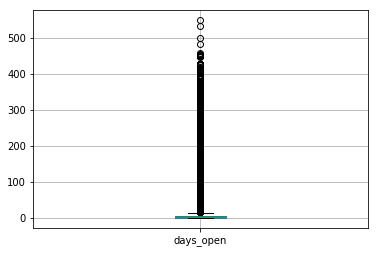

In [22]:
# View box plot of number of days open, to visually inspect outliers
df1617.boxplot(column='days_open')

#### Outliers
The 75th percentile is 6 days, for number of days each case is open. This implies any case open longer than a week is an outlier. This will need to be examined for each type of case.

## 311 Data - 2018

This data is updated daily, and will be kept separate from the 2016 and 2017 data.

In [23]:
url = 'https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Public_311_2018_YTD/FeatureServer/0/query?where=1%3D1&outFields=CASEID,ENQUIRYTYPEID,SUBJECTNAME,REASONNAME,TYPENAME,TITLE,OPENEDDATETIME,CASESTATUS,CLOSEDDATETIME,XCOORD,YCOORD,OBJECTID&outSR=4326&f=json'
r = requests.get(url)
api_json_data = r.json()

data_entries = api_json_data['features']
df18 = json_normalize(data_entries)

# Standardize column names 
new_col_names = ['case_id', 'status', 'closed_date', 'enquiry_type_id', 'object_id', 
                 'opened_date', 'reason', 'subject', 'title', 'type_name', 
                 'x_coord', 'y_coord', 'x_geom', 'y_geom']
df18.columns = new_col_names

In [24]:
# Convert 'OpenDateTime' values to datetime objects
df18['opened_date'] = df18['opened_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat())
# Convert 'CloseDateTime' values to datetime objects, unless NaN
df18['closed_date'] = df18['closed_date'].apply(lambda x: datetime.fromtimestamp(x/1000).isoformat() 
                                               if pd.notnull(x) else x)
df18['days_open'] = df18.apply(lambda row: days_open(row), axis=1)

In [25]:
# Convert dates to pandas datetime format.
df18['opened_date'] = pd.to_datetime(df18['opened_date'], format='%Y-%m-%dT%H:%M:%S')
df18['closed_date'] = pd.to_datetime(df18['closed_date'], format='%Y-%m-%dT%H:%M:%S')

# Sort by opened_date
df18 = df18.sort_values(by = 'opened_date')

# Set the opened date as the index.
df18 = df18.set_index('opened_date')
df18.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open
opened_date,,,,,,,,,,,,,,
2017-12-31 18:05:00,101004120778,0,2018-01-02 02:38:36,101002181,23342,Graffiti / Clean City,Public Safety,Graffiti - Open311,Graffiti - Open311,-1.038604e+07,5.608372e+06,-93.299350,44.916415,1.0
2017-12-31 21:37:13,101004120779,0,2018-01-01 13:26:45,101002281,23344,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038293e+07,5.614953e+06,-93.271489,44.958263,0.0
2018-01-01 03:58:42,101004120781,0,2018-01-10 18:58:21,101000108,38167,Traffic Control,Vehicles and Commuting,Abandoned Vehicle,Abandoned Vehicle,-1.037949e+07,5.611866e+06,-93.240585,44.938632,9.0
2018-01-01 04:05:00,101004120782,0,2018-01-01 14:06:33,101002281,26286,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.037665e+07,5.616573e+06,-93.215065,44.968555,0.0
2018-01-01 04:13:21,101004120783,0,2018-01-02 02:34:11,101000022,38168,Street Maintenance,Streets,Pothole,Pothole,-1.038766e+07,5.621619e+06,-93.313969,45.000618,0.0


In [26]:
df18.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38473 entries, 2017-12-31 18:05:00 to 2018-07-27 14:44:00
Data columns (total 14 columns):
case_id            38473 non-null int64
status             38473 non-null int64
closed_date        36347 non-null datetime64[ns]
enquiry_type_id    38473 non-null int64
object_id          38473 non-null int64
reason             38473 non-null object
subject            38473 non-null object
title              38473 non-null object
type_name          38473 non-null object
x_coord            38473 non-null float64
y_coord            38473 non-null float64
x_geom             38473 non-null float64
y_geom             38473 non-null float64
days_open          36347 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 4.4+ MB


## Climate data - 2017
Historical climate data from the State of Minnesota. Columns include:
* Maximum Temperature (F)
* Minimum Temperature (F)
* Precipitation (Inches)
* Snow Fall (Inches)
* Snow Depth (Inches)

In [63]:
df_weather = pd.read_csv("Climate_Data_16_17.csv", index_col = 'Date', parse_dates = True)

# Standardize column names 
new_col_names = ['max_temp', 'min_temp', 'precipitation', 'snow', 'snow_depth']
df_weather.columns = new_col_names

df_weather.head()  # T = trace amounts

,max_temp,min_temp,precipitation,snow,snow_depth
Date,,,,,
2016-01-01,30,15,T,T,4
2016-01-02,31,14,0,0,4
2016-01-03,29,20,0,0,4
2016-01-04,26,10,0,0,4
2016-01-05,32,20,0,0,4


In [69]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 933 entries, 2016-01-01 to 2018-07-21
Data columns (total 5 columns):
max_temp         933 non-null int64
min_temp         933 non-null int64
precipitation    933 non-null object
snow             933 non-null object
snow_depth       933 non-null object
dtypes: int64(2), object(3)
memory usage: 43.7+ KB


In [65]:
df_weather['precipitation'].value_counts(dropna=False).head(10)

0       474
T       147
0.01     43
0.02     21
0.04     16
0.05     13
0.08     12
0.07     12
0.03     11
0.09      8
Name: precipitation, dtype: int64

In [66]:
df_weather['snow'].value_counts(dropna=False).head(10)

0      763
T       86
0.1     14
0.3      8
0.6      7
0.4      5
0.2      4
0.5      4
2.1      3
0.7      3
0.8      3
1.1      3
1.3      2
1.2      2
0.9      2
Name: snow, dtype: int64

In [67]:
df_weather['snow_depth'].value_counts(dropna=False).head(10)

0     658
2      62
1      46
T      43
5      42
3      26
4      23
6      11
7       8
8       5
9       5
10      2
11      2
Name: snow_depth, dtype: int64

In [68]:
# Some precipitation, snow, and snow depth entries are "T" for "trace amounts".
# Current minimum values in each column are 0.01 inches (precipitation, snow) and 0.1 inches (snow depth).
# Replace these "T" values with a half increment.

df_weather.precipitation = df_weather.precipitation.replace('T', 0.005)
df_weather.snow = df_weather.snow.replace('T', 0.005)
df_weather.snow_depth = df_weather.snow_depth.replace('T', 0.05)

# Coerce the values into numeric types, after removing any string values.

df_weather.precipitation = pd.to_numeric(df_weather.precipitation)
df_weather.snow = pd.to_numeric(df_weather.snow)
df_weather.snow_depth = pd.to_numeric(df_weather.snow_depth)
df_weather.info()

,max_temp,min_temp,precipitation,snow,snow_depth
Date,,,,,
2016-01-01,30,15,0.005,0.005,4
2016-01-02,31,14,0,0,4
2016-01-03,29,20,0,0,4
2016-01-04,26,10,0,0,4
2016-01-05,32,20,0,0,4
2016-01-06,33,23,0.05,0.4,4
2016-01-07,34,31,0.04,0.4,4
2016-01-08,34,22,0.08,1.2,5
2016-01-09,22,-6,0.005,0.005,5


In [76]:
df_weather.describe()

,max_temp,min_temp,precipitation,snow,snow_depth
count,933.000000,933.000000,933.000000,933.000000,933.000000
mean,56.556270,39.757771,0.097208,0.142369,0.858682
std,23.756777,21.887178,0.269279,0.822557,1.856775
min,-6.000000,-20.000000,0.000000,0.000000,0.000000
25%,37.000000,24.000000,0.000000,0.000000,0.000000
50%,60.000000,42.000000,0.000000,0.000000,0.000000
75%,78.000000,60.000000,0.040000,0.000000,0.050000
max,100.000000,77.000000,2.180000,12.400000,11.000000


## Combine 311 and climate dataframes
* Separate the date and time values from the opened_date index. These will be saved in new columns called 'open_day' and 'open_time'.
* Use multi indexing to isolate the date each case was opened.
* Merge the climate data and 311 data by matching the opened date.

In [34]:
# Need to create date column in order to combine with weather data.
df1617['open_day'] = df1617.index.date
df1617['open_time'] = df1617.index.time
df1617.head()

,case_id,status,closed_date,enquiry_type_id,object_id,reason,subject,title,type_name,x_coord,y_coord,x_geom,y_geom,days_open,open_date,open_time
opened_date,,,,,,,,,,,,,,,,
2016-01-01 00:10:35,101003839191,0,2016-01-02 12:03:41,101002221,2196,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,Abandoned Vehicle - Open311,-1.038160e+07,5.613667e+06,-93.259481,44.950087,1.0,2016-01-01,00:10:35
2016-01-01 07:50:34,101003839192,0,2016-01-02 09:08:54,101002281,29550,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038520e+07,5.616158e+06,-93.291802,44.965918,1.0,2016-01-01,07:50:34
2016-01-01 08:46:35,101003839193,0,2016-02-08 11:28:20,101001081,19633,Snow & Ice,Sidewalks,Sidewalk Snow and Ice - SS,Sidewalk Snow and Ice - SS,-1.037889e+07,5.625311e+06,-93.235196,45.024063,38.0,2016-01-01,08:46:35
2016-01-01 09:35:17,101003839194,0,2016-01-04 09:30:00,101000093,19634,Traffic Control,Vehicles and Commuting,Parking Violation Complaint,Parking Violation Complaint,-1.038501e+07,5.604598e+06,-93.290172,44.892400,2.0,2016-01-01,09:35:17
2016-01-01 10:00:34,101003839195,0,2016-01-02 09:37:55,101002281,2197,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,Parking Violation - Open311,-1.038350e+07,5.615948e+06,-93.276582,44.964583,0.0,2016-01-01,10:00:34


In [36]:
#df1617.index = pd.MultiIndex.from_arrays([df1617.index.date, df1617.index.time], names=['Date','Time'])
df1617.index = pd.MultiIndex.from_arrays([df1617.index.date, df1617.index.time], names=['Date','Time'])


In [77]:
df1617weather = pd.merge(df1617, df_weather, left_index=True, right_index=True, how = 'left')
df1617weather.head()

case_id  status         closed_date  \
Date       Time                                                 
2016-01-01 00:10:35  101003839191       0 2016-01-02 12:03:41   
           07:50:34  101003839192       0 2016-01-02 09:08:54   
           08:46:35  101003839193       0 2016-02-08 11:28:20   
           09:35:17  101003839194       0 2016-01-04 09:30:00   
           10:00:34  101003839195       0 2016-01-02 09:37:55   

                     enquiry_type_id  object_id           reason  \
Date       Time                                                    
2016-01-01 00:10:35        101002221       2196  Traffic Control   
           07:50:34        101002281      29550  Traffic Control   
           08:46:35        101001081      19633       Snow & Ice   
           09:35:17        101000093      19634  Traffic Control   
           10:00:34        101002281       2197  Traffic Control   

                                    subject                        title  \
Date       Time                                                            
2016-01-01 00:10:35  Vehicles and Commuting  Abandoned Vehicle - Open311   
           07:50:34  Vehicles and Commuting  Parking Violation - Open311   
           08:46:35               Sidewalks   Sidewalk Snow and Ice - SS   
           09:35:17  Vehicles and Commuting  Parking Violation Complaint   
           10:00:34  Vehicles and Commuting  Parking Violation - Open311   

                                       type_name       x_coord     ...      \
Date       Time                                                    ...       
2016-01-01 00:10:35  Abandoned Vehicle - Open311 -1.038160e+07     ...       
           07:50:34  Parking Violation - Open311 -1.038520e+07     ...       
           08:46:35   Sidewalk Snow and Ice - SS -1.037889e+07     ...       
           09:35:17  Parking Violation Complaint -1.038501e+07     ...       
           10:00:34  Parking Violation - Open311 -1.038350e+07     ...       

                        x_geom     y_geom  days_open   open_date open_time  \
Date       Time                                                              
2016-01-01 00:10:35 -93.259481  44.950087        1.0  2016-01-01  00:10:35   
           07:50:34 -93.291802  44.965918        1.0  2016-01-01  07:50:34   
           08:46:35 -93.235196  45.024063       38.0  2016-01-01  08:46:35   
           09:35:17 -93.290172  44.892400        2.0  2016-01-01  09:35:17   
           10:00:34 -93.276582  44.964583        0.0  2016-01-01  10:00:34   

                    max_temp  min_temp  precipitation   snow  snow_depth  
Date       Time                                                           
2016-01-01 00:10:35       30        15          0.005  0.005         4.0  
           07:50:34       30        15          0.005  0.005         4.0  
           08:46:35       30        15          0.005  0.005         4.0  
           09:35:17       30        15          0.005  0.005         4.0  
           10:00:34       30        15          0.005  0.005         4.0  

[5 rows x 21 columns]

In [83]:
df1617weather.to_csv('311_clean.csv')